In [103]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [104]:
df = pd.concat([pd.read_csv(f) for f in glob.glob('cork_property_prices*.csv')], ignore_index = True)
df = df.drop_duplicates(subset='listing_id', keep='first') # Dedup on listing_id and keep first record.
# Clean data
df['cost'] = df['cost'].str.replace(",","") # Remove commas in cost column
df = df[(df.cost.str.isnumeric() == True)] # Remove rows with alpha characters
df['cost'] = pd.to_numeric(df['cost'])
df['cost'] = df['cost']/1000 # In K units

# Create an ordinal equivalent of BER
df['ber'] = pd.Categorical(df['ber'])
df['ber_ord'] = df.ber.cat.codes

# 1-hot the categoricals
loc_cat = pd.get_dummies(df.location, prefix = 'loc')
type_cat = pd.get_dummies(df.property_type, prefix = 'typ')
#df = pd.concat([df,y], axis=1)
df = pd.concat([df,loc_cat,type_cat], axis=1)
df.shape
df


,listing_id,location,address,beds,bathrooms,cost,num_pics,property_type,ber,ber_ord,...,loc_douglas,loc_glasheen,loc_grange,loc_model-farm-road,loc_wilton,typ_Detached House,typ_End of Terrace House,typ_Semi-Detached House,typ_Terraced House,typ_Townhouse
0,2549894,douglas,Kincora| South Douglas Road| Douglas| Co. Cork,3,1,259.0,24,Semi-Detached House,NaN,-1,...,1,0,0,0,0,0,0,1,0,0
1,2255069,douglas,Denmead| 38 Hettyfield Park| Douglas| Co. Cork,4,4,795.0,23,Detached House,D1,7,...,1,0,0,0,0,1,0,0,0,0
2,2217312,douglas,80 Yewlands| Maryborough Woods| Douglas| Co. Cork,3,3,310.0,8,Terraced House,C1,4,...,1,0,0,0,0,0,0,0,1,0
3,2548380,douglas,115 Greenhills Court| South Douglas Road| Doug...,3,2,245.0,33,Terraced House,C3,6,...,1,0,0,0,0,0,0,0,1,0
4,2255031,douglas,10 Springbrook| Donnybrook| Douglas| Co. Cork,3,3,249.0,16,Semi-Detached House,D1,7,...,1,0,0,0,0,0,0,1,0,0
5,2154356,douglas,Clogheen| Hettyfield Park| Douglas| Co. Cork,5,4,725.0,33,Detached House,D1,7,...,1,0,0,0,0,1,0,0,0,0
6,2069030,douglas,8 Lislee Road| Maryborough Estate| Douglas| Co...,4,2,489.0,12,Detached House,D2,8,...,1,0,0,0,0,1,0,0,0,0
7,2125026,douglas,Emeralda| 12 Ballincurrig Park| Douglas| Co. Cork,4,1,425.0,18,Semi-Detached House,D2,8,...,1,0,0,0,0,0,0,1,0,0
8,2526196,douglas,10 Rathmore Lawn| Douglas| Co. Cork,3,1,375.0,10,Semi-Detached House,E1,9,...,1,0,0,0,0,0,0,1,0,0
9,2563871,douglas,16 Inchvale Close| Shamrock Lawn| Douglas| Co....,3,1,240.0,14,Semi-Detached House,_G,12,...,1,0,0,0,0,0,0,1,0,0


In [105]:
# 75:25 train:test split.
from sklearn.model_selection import train_test_split
# df = df.drop(['listing_id','location','address','property_type','ber'], axis=1)
train, test = train_test_split(df, test_size=0.2)
x = train.drop(['listing_id','location','address','property_type','ber','cost'], axis=1)
y = train.cost

In [106]:
import xgboost as xgb
xgr = xgb.XGBRegressor(random_state=42, n_jobs=8)
xgr.fit(x,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

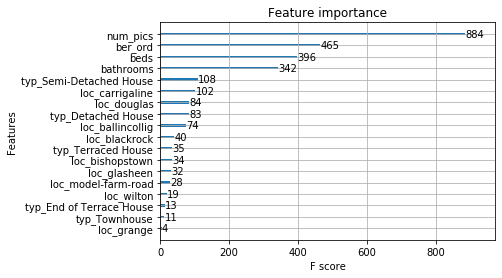

In [107]:
xgb.plot_importance(xgr)

In [108]:
test_x = test.drop(['listing_id','location','address','property_type','ber','cost'], axis=1)
preds = xgr.predict(test_x)
test.cost - preds
rmse = np.sqrt(mean_squared_error(test.cost, preds))
print("RMSE: %f" % (rmse))
print("MSE: ", mean_squared_error(test.cost, preds))
print("Mean Absolute Error: %f" % mean_absolute_error(test.cost,preds))
print("R2: ", r2_score(test.cost,preds))

RMSE: 141.299568
MSE:  19965.5678408953
Mean Absolute Error: 68.070692
R2:  0.5988091522231868


In [109]:
preds

array([ 306.20236,  265.52985,  300.0657 ,  527.94464,  858.39874,
        614.731  ,  456.6741 ,  248.65477,  617.45416,  431.9256 ,
        234.46848,  232.03343, 1056.0847 ,  319.13947,  300.76166,
        173.55968,  404.37714,  395.56308,  274.69763,  275.08752,
        222.91249,  260.2737 ,  252.50284,  337.91858,  667.2166 ,
        345.7829 ,  577.06537,  413.93713,  343.91183,  185.63402,
        299.37286,  398.5028 ,  849.0294 ,  254.42361,  249.21916,
        393.53906,  507.78885,  311.68027,  320.41574,  416.7916 ,
        326.72324,  254.6385 ,  531.0286 ,  185.41919,  381.31348],
      dtype=float32)

In [110]:
test2 = test.copy()
test2['preds'] = preds

In [111]:
test2[['beds','bathrooms','num_pics','cost','preds']]

,beds,bathrooms,num_pics,cost,preds
157,3,2,21,430.0,306.202362
417,3,1,48,250.0,265.529846
166,3,1,22,300.0,300.065704
424,4,2,16,565.0,527.944641
34,4,4,31,670.0,858.398743
204,5,3,27,540.0,614.731018
160,4,2,12,449.0,456.674103
129,3,2,16,255.0,248.654770
155,5,3,27,540.0,617.454163
46,4,4,14,310.0,431.925598


In [102]:
df.iloc[[87]]

,listing_id,location,address,beds,bathrooms,cost,num_pics,property_type,ber,ber_ord,...,loc_douglas,loc_glasheen,loc_grange,loc_model-farm-road,loc_wilton,typ_Detached House,typ_End of Terrace House,typ_Semi-Detached House,typ_Terraced House,typ_Townhouse
90,2551201,carrigaline,39 Rosebay Drive| Forest Hill| Carrigaline| Co...,3,3,335.0,18,Semi-Detached House,B3,3,...,0,0,0,0,0,0,0,1,0,0
